# Velocity Measurement from PMDI High Speed Images

This program measures the velocity of a PMDI spray from high speed images.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 19/05/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia



In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate, scipy.signal
from joblib import Parallel, delayed
%matplotlib notebook


In [2]:
# Define where images come from.
root_dir = "/home/dduke/Desktop/"

source_images = root_dir + "23_05_2019_12b"
bkgnd_images = root_dir + "23_05_2019_12a"
frame_rate = 60000.
spatial_res = 0.001/96. # metres per pixel
bkgnd_frames=(1,50)
roi = (40,160,0,80)

## Load images
Crop and mask as required. Remove background.

In [3]:
I=ImageSequence(source_images, IO_threads=4)
B=ImageSequence(bkgnd_images, IO_threads=4, frames=bkgnd_frames)

Reading /home/dduke/Desktop/23_05_2019_12b
	Found 70000 images with extension .tif
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
40 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   11.3s finished


Read 1709.0 MiB in 12.3 sec
	Data in memory:	 (70000, 80, 160)
	Intensity range:	 0 to 25608 	 uint32
	Array size:	3418.0 MB
Reading /home/dduke/Desktop/23_05_2019_12a
	Found 50001 images with extension .tif
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
4 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Read 1.2 MiB in 0.5 sec
	Data in memory:	 (49, 80, 160)
	Intensity range:	 0 to 25608 	 uint32
	Array size:	2.4 MB


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


<IPython.core.display.Javascript object>


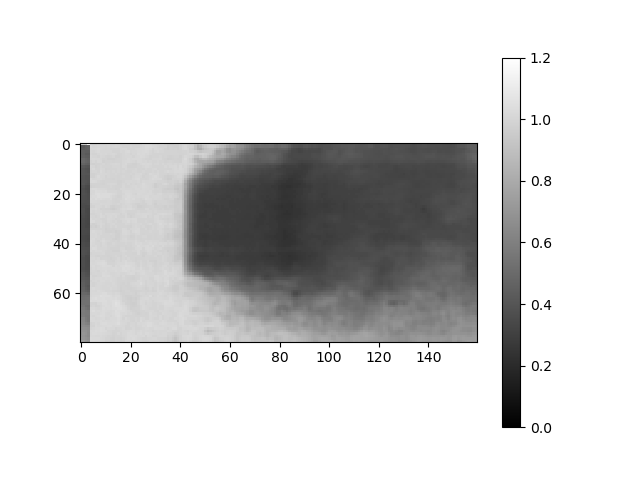

In [4]:
# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = np.nanmean(B.arr,axis=0).astype(np.float32)
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd

plt.figure()
h=plt.imshow(Ib[3333,...],cmap=plt.cm.gray,vmin=0,vmax=1.2)
plt.colorbar(h);

Frame range for analysis: 0 - 37287


<IPython.core.display.Javascript object>


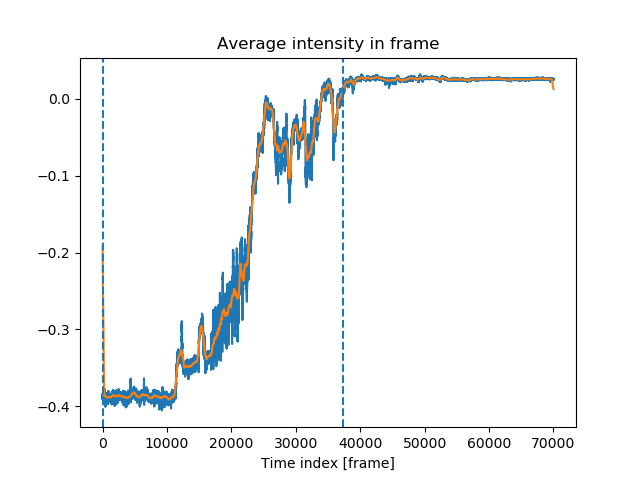

Text(0.5, 0, 'Time index [frame]')

In [5]:
# Find valid region in time for analysis
avg_intensity = np.nanmean(np.nanmean(Ib,axis=-1),axis=-1)
avg_intensity -=  np.median(avg_intensity)

# Rolling average (smooth)
ww=500
rolling_avg_intensity = np.convolve(avg_intensity, np.ones(ww,), 'same')/float(ww)

# Find steady region
t0=np.where(rolling_avg_intensity<0)[0][0]
# Find end of steady region
t1=np.where(np.abs(rolling_avg_intensity)<0.01)[0][-1]
print("Frame range for analysis: %i - %i" % (t0,t1))

# Get co-ordinates
y = np.arange(Ib.shape[1])
x = np.arange(Ib.shape[2])
t = np.arange(Ib.shape[0])

plt.figure()
plt.plot(t,avg_intensity)
plt.plot(t,rolling_avg_intensity)
#plt.ylim(-.1,.1)
plt.axvline(t0,ls='--')
plt.axvline(t1,ls='--')
plt.title("Average intensity in frame")
plt.xlabel("Time index [frame]")

## Cross-correlation analysis
Estimate velocity from cross-correlation of liquid structures in the streamwise direction.

In [6]:
x_roi = x[roi[0]:roi[1]]
y_roi = y[roi[2]:roi[3]]
Is = Ib[t0:t1,roi[2]:roi[3],roi[0]:roi[1]]
print("Size of data subset:" + str(Is.shape))

def one_cc(frames):
    f1=np.fft.fft2(frames[0,...])
    f2=np.fft.fft2(frames[1,...])
    ac=np.fft.ifft2(f1*np.conj(f1))
    cc=np.fft.ifft2(f1*np.conj(f2))
    cc = np.abs(cc-ac)
    cc[cc<0]=0
    return cc

ccs = Parallel(n_jobs=-1,verbose=5)(delayed(one_cc)(Is[i-1:i+1]) for i in range(1,Is.shape[0]))
c = np.fft.fftshift( np.nanmean(np.dstack(ccs),axis=-1) )

Size of data subset:(37287, 80, 120)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 8256 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 14592 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 22080 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 30720 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 37092 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 37286 out of 37286 | elapsed:   15.9s finished


<IPython.core.display.Javascript object>


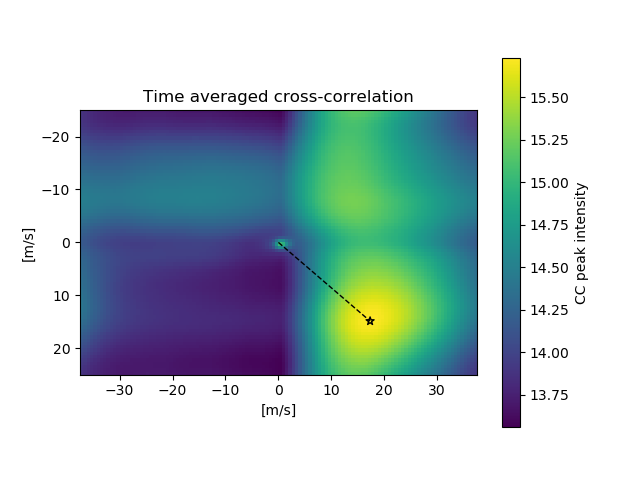

Peak CC at u_x = 17.331933, u_y = 14.873418, U = 22.838880 m/s


In [7]:
# convert displacements to velocities [px/frame]
wy = np.linspace(-.5,.5,c.shape[0])*c.shape[0]
wx = np.linspace(-.5,.5,c.shape[1])*c.shape[1]

# velocities [m/s]
py = wy*frame_rate*spatial_res # convert px/frame to m/s
px = wx*frame_rate*spatial_res # convert px/frame to m/s

fig=plt.figure()
h=plt.imshow(c,extent=[px.min(), px.max(), -py.min(), -py.max()])
plt.colorbar(h,label='CC peak intensity');
plt.xlabel("[m/s]")
plt.ylabel("[m/s]")
plt.title("Time averaged cross-correlation");

pxx,pyy = np.meshgrid(px,py)
rads = np.sqrt(pxx**2 + pyy**2)
peak_location = np.where(c==np.nanmax(c[rads>1]))
peak_x = px[peak_location[1][0]]
peak_y = py[peak_location[0][0]]
peak_r = np.sqrt(peak_x**2 + peak_y**2)
print("Peak CC at u_x = %f, u_y = %f, U = %f m/s" % (peak_x,peak_y,peak_r))

plt.scatter(peak_x,peak_y,marker='*',edgecolor='k',facecolor='None')
plt.plot((0,peak_x),(0,peak_y),ls='--',c='k',lw=1)

<IPython.core.display.Javascript object>


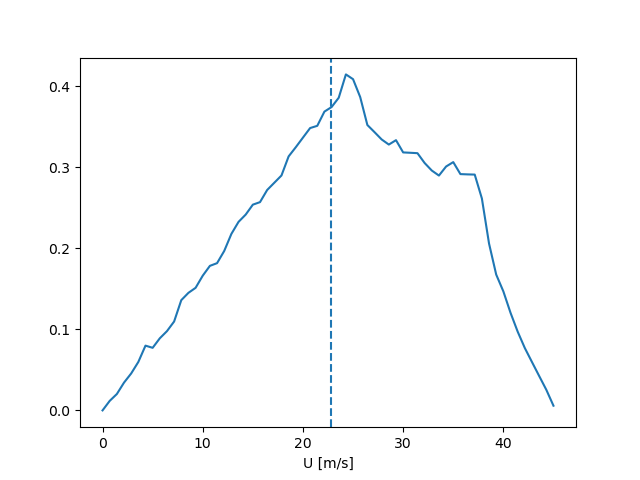

In [8]:
# Plot the velocity magnitude probability 
r = np.linspace(0,np.sqrt(px.max()**2 + py.max()**2),64)
pxx,pyy = np.meshgrid(px,py)
rads = np.sqrt(pxx**2 + pyy**2)

U = np.zeros_like(r)
for i in range(len(r)):
    if i == 0:
        U[i] = np.sum(c[rads <= r[i]])
    elif i == len(r)-1:
        U[i] = np.sum(c[rads >= r[i]])
    else:
        U[i] = np.sum(c[(rads > r[i-1])&(rads < r[i+1])])
    
    if i < len(r)-1:
        U[i] /= (r[i+1] - r[i-1])**2
    
U /= np.product(c.shape)
    
plt.figure()
plt.plot(r, U)
plt.xlabel("U [m/s]")
plt.axvline(peak_r,ls='--');